# Contralateral Delay Activity (CDA): 
Data Preparation; Visualizations & Visual Inspection; Average CDA amplitude extraction. 

In [1]:
import pandas as pd
import numpy as np
import scipy.io as spio
import openpyxl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

* Data was extracted from PO7/PO8 electrodes (data from each hemisphere will be processed separately. 
* ERPs are averaged ERPs for each condition (3D, 3K, 4D, 4K)
* In the Excel document there are many sheets, each sheet with data from one participant in one out of four conditions

## **Process ERP Data, Extract CDA**

**CDA** is calculated as a difference between contralateral and ipsilateral waves (CDA = contra - ipsi).

In [2]:
def process_erp_data(input_file_path, hemisphere, output_file_name = None):
    """
    Processes ERP data, calculating ipsilateral, contralateral, and CDA values for each condition.
    
    - input_file_path: Path to an Excel file with ERP data
    - hemisphere: Hemisphere for which the ERP data is being processed (left or right)
    - output_file_name (optional): a Path to save the averaged data as an Excel file.
    
    """
    
    xlsx = pd.ExcelFile(input_file_path)
    data_by_condition = {}

    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name = sheet_name)
        sheet_info = sheet_name.split('_')
        subject_id = sheet_info[0]
        condition = {'3D': '3R', '4D': '4R', '3K': '3L', '4K': '4L'}.get(sheet_info[2])

        if not condition:
            print(f"Unexpected condition found in sheet: {sheet_name}")
            continue

        df.rename(columns = {df.columns[0]: 'time', df.columns[1]: subject_id}, inplace = True)

        if condition not in data_by_condition:
            data_by_condition[condition] = df
        else:
            data_by_condition[condition] = pd.merge(data_by_condition[condition], df, on = 'time', how = 'outer')

    # Calculating ipsilateral and contralateral waves
    if hemisphere == 'right':
        ipsi = (data_by_condition['3R'] + data_by_condition['4R']) / 2
        contra = (data_by_condition['3L'] + data_by_condition['4L']) / 2
        ipsi_3 = data_by_condition['3R']
        contra_3 = data_by_condition['3L']
        ipsi_4 = data_by_condition['4R']
        contra_4 = data_by_condition['4L']
    elif hemisphere == 'left':
        ipsi = (data_by_condition['3L'] + data_by_condition['4L']) / 2
        contra = (data_by_condition['3R'] + data_by_condition['4R']) / 2
        ipsi_3 = data_by_condition['3L']
        contra_3 = data_by_condition['3R']
        ipsi_4 = data_by_condition['4L']
        contra_4 = data_by_condition['4R']
    else:
        raise ValueError("Hemisphere must be 'right' or 'left'.")
    
    # Calculating CDA 

    # averaged for 3 and 4 stimuli
    cda = contra.copy()
    cda.iloc[:, 1:] = contra.iloc[:, 1:] - ipsi.iloc[:, 1:]

    # 3 stimuli
    cda_3 = contra_3.copy()
    cda_3.iloc[:, 1:] = contra_3.iloc[:, 1:] - ipsi_3.iloc[:, 1:]

    # 4 stimuli
    cda_4 = contra_4.copy()
    cda_4.iloc[:, 1:] = contra_4.iloc[:, 1:] - ipsi_4.iloc[:, 1:]

    # Storing data in a dictionary
    waves = {'ipsi': ipsi, 'contra': contra, 'CDA': cda, 'CDA_3': cda_3, 'CDA_4': cda_4}
    waves.update(data_by_condition)

    if output_file_name:
        with pd.ExcelWriter(output_file_name) as writer:
            for name, df in waves.items():
                cols = ['time'] + [col for col in df if col not in ['time']]
                df = df[cols]
                df.to_excel(writer, sheet_name = name, index=False)

    return waves

In [3]:
# process the data from left (PO7) and right (PO8) hemisphere
PO8_contra_ipsi_CDA = process_erp_data(input_file_path = 'raw_data/MATLAB_ERP_PO8.xls',  hemisphere = 'right', output_file_name = "PO8_contra_ipsi_CDA.xlsx")
PO7_contra_ipsi_CDA = process_erp_data(input_file_path = 'raw_data/MATLAB_ERP_PO7.xls',  hemisphere = 'left', output_file_name = "PO7_contra_ipsi_CDA.xlsx")

## **Remove Subjects' Data**

In [4]:
def remove_subjects(input_data, subjects_to_remove, output_file_path = None):
    """
    
    Removes specified subjects' ERP data.
    Optional: saves the cleaned data to a new Excel file.
    
    - input_data: A dictionary containing ERP DataFrames.
    - subjects_to_remove: List of subject IDs to remove.
    - output_file_path (optional): path for the output Excel file. If not provided, no file will be saved.
    
    """
    data_removed_subjects = {}
    
    for sheet_name, df in input_data.items():
        # Remove columns corresponding to subjects_to_remove
        df = df.loc[:, ~df.columns.isin(subjects_to_remove)]
        data_removed_subjects[sheet_name] = df

    if output_file_path:
        with pd.ExcelWriter(output_file_path, engine = 'openpyxl') as writer:
            for name, data in data_removed_subjects.items():
                data.to_excel(writer, sheet_name = name, index=False)

    return data_removed_subjects

In [5]:
# List of subjects to remove
subjects_to_remove_path = '/Users/linagladutyte/Documents/LABES/VWM PAPER/analysis_scripts/subjects_to_remove.txt'
with open(subjects_to_remove_path, "r") as file:
    subjects_to_remove = [line.strip() for line in file]

print(subjects_to_remove)

['108', '123', '205', '316', '102', '109', '133', '236', '237', '333', '202', '213', '6', '603', '604', '614', '618', '624', '628', '627']


In [6]:
# Remove subject's data
PO8_contra_ipsi_CDA_removed_subjects = remove_subjects(PO8_contra_ipsi_CDA , subjects_to_remove, output_file_path = "PO8_contra_ipsi_CDA_removed_subjects.xlsx")
PO7_contra_ipsi_CDA_removed_subjects = remove_subjects(PO7_contra_ipsi_CDA , subjects_to_remove, output_file_path = "PO7_contra_ipsi_CDA_removed_subjects.xlsx")

## **Calculate Average Ipsi-, Contra-lateral, and CDA Waves**

In [7]:
def average_data(df):
    # Excluding 'time' column from the average calculation
    avg_data = df.iloc[:, 1:].mean(axis=1)
    return avg_data



def calculate_waves_for_plotting(po7_data, po8_data, output_file_path = None):
    """
    
    Prepares processed ERP data for plotting and visual inspection by calculating average values of ipsilateral, contralateral, and Contralateral Delay Activity (CDA) waves. 

    - po7_data: Dictionary of DataFrames for the PO7 hemisphere data.
    - po8_data: Dictionary of DataFrames for the PO8 hemisphere data.
    - output_file_path (optional): Path to save the averaged data as an Excel file.
    
    """
    
    waves_for_plotting = {}
    time_column = po7_data['ipsi']['time'].reset_index(drop = True)
    
    for data, hemisphere in [(po7_data, 'PO7'), (po8_data, 'PO8')]:
        avg_ipsi = average_data(data['ipsi'])
        avg_contra = average_data(data['contra'])
        avg_cda = average_data(data['CDA'])

        # Combine time column with averages
        avg_df = pd.DataFrame({
            'time': time_column,
            f'avg_ipsi_{hemisphere}': avg_ipsi,
            f'avg_contra_{hemisphere}': avg_contra,
            f'avg_cda_{hemisphere}': avg_cda
        })
        waves_for_plotting[f'avg_{hemisphere}'] = avg_df

    # Combine PO7 and PO8 
    avg_ipsi_combined = (po7_data['ipsi'].iloc[:, 1:].mean(axis=1) + po8_data['ipsi'].iloc[:, 1:].mean(axis=1)) / 2
    avg_contra_combined = (po7_data['contra'].iloc[:, 1:].mean(axis=1) + po8_data['contra'].iloc[:, 1:].mean(axis=1)) / 2
    avg_cda_combined = (po7_data['CDA'].iloc[:, 1:].mean(axis=1) + po8_data['CDA'].iloc[:, 1:].mean(axis=1)) / 2

    avg_combined_df = pd.DataFrame({
        'time': time_column,
        'avg_ipsi_combined': avg_ipsi_combined,
        'avg_contra_combined': avg_contra_combined,
        'avg_cda_combined': avg_cda_combined
    })
    waves_for_plotting['avg_PO8_PO7'] = avg_combined_df

    if output_file_path:
        with pd.ExcelWriter(output_file_path, engine = 'openpyxl') as writer:
            for name, df in waves_for_plotting.items():
                df.to_excel(writer, sheet_name = name, index = False)

    return waves_for_plotting

In [8]:
# Calculte waves for plotting
waves_for_plotting = calculate_waves_for_plotting(PO7_contra_ipsi_CDA_removed_subjects, PO8_contra_ipsi_CDA_removed_subjects, output_file_path = 'PO7_PO8_waves_for_plotting.xlsx')

## **Plot CDA Waves**

In [9]:
def plot_CDA_hemispheres(waves_for_plotting, save_path = None):
    """
    
    Plots ipsi- and contra- lateral waves, and corresponding CDA waves for each hemisphere. Optionally, saves figure to png file. 

    waves_for_plotting: A dictionary containing pre-calculated ipsilateral, contralateral, and CDA waves DataFrames for each hemisphere.
    save_path (optional): path to the output png file
    
    """
    
    fig, axs = plt.subplots(2, 2, figsize = (16, 10))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
  
    font_size = 20 
    legend_font_size = 15

    # Iterate over all subplots to set properties
    for ax in axs.flat:
        # Font size
        ax.set_title(ax.get_title(), fontsize = font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = font_size)
        
        ax.tick_params(axis = 'both', which = 'major', labelsize = font_size)
 
    # Left hemisphere (PO7)
    axs[0, 0].plot(waves_for_plotting['avg_PO7']['time'], waves_for_plotting['avg_PO7']['avg_contra_PO7'], color = 'mediumvioletred', label = 'Contralateral')
    axs[0, 0].plot(waves_for_plotting['avg_PO7']['time'], waves_for_plotting['avg_PO7']['avg_ipsi_PO7'], color = 'black', label = 'Ipsilateral')
    axs[0, 0].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[0, 0].set_title('Left hemisphere (PO7)', fontsize = font_size)
    axs[0, 0].set_xlabel('Time (ms)', fontsize = font_size)
    axs[0, 0].set_ylabel('Potential (µV)', fontsize = font_size)
    axs[0, 0].legend(fontsize = legend_font_size, loc = 'upper center')

    # Right hemisphere (PO8)
    axs[0, 1].plot(waves_for_plotting['avg_PO8']['time'], waves_for_plotting['avg_PO8']['avg_contra_PO8'], color = 'mediumvioletred', label = 'Contralateral')
    axs[0, 1].plot(waves_for_plotting['avg_PO8']['time'], waves_for_plotting['avg_PO8']['avg_ipsi_PO8'], color = 'black', label = 'Ipsilateral')
    axs[0, 1].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[0, 1].set_title('Right hemisphere (PO8)', fontsize = font_size)
    axs[0, 1].set_xlabel('Time (ms)', fontsize = font_size)
    axs[0, 1].set_ylabel('Potential (µV)', fontsize = font_size)
    axs[0, 1].legend(fontsize = legend_font_size, loc = 'upper center')

    # CDA for left hemisphere (PO7)
    axs[1, 0].plot(waves_for_plotting['avg_PO7']['time'], waves_for_plotting['avg_PO7']['avg_cda_PO7'], color = 'black')
    axs[1, 0].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[1, 0].set_title('CDA - Left hemisphere (PO7)', fontsize = font_size)
    axs[1, 0].set_xlabel('Time (ms)', fontsize = font_size)
    axs[1, 0].set_ylabel('Potential (µV)', fontsize = font_size)

    # CDA for right hemisphere (PO8)
    axs[1, 1].plot(waves_for_plotting['avg_PO8']['time'], waves_for_plotting['avg_PO8']['avg_cda_PO8'], color = 'black')
    axs[1, 1].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[1, 1].set_title('CDA - Right hemisphere (PO8)', fontsize = font_size)
    axs[1, 1].set_xlabel('Time (ms)', fontsize = font_size)
    axs[1, 1].set_ylabel('Potential (µV)', fontsize = font_size)

    # Set the same y-axis limits for all subplots
    all_axes = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
    ymin, ymax = min(ax.get_ylim()[0] for ax in all_axes), max(ax.get_ylim()[1] for ax in all_axes)
    for ax in all_axes:
        ax.set_ylim([ymin, ymax])

    fig.savefig(save_path, dpi = 300)
    plt.show()

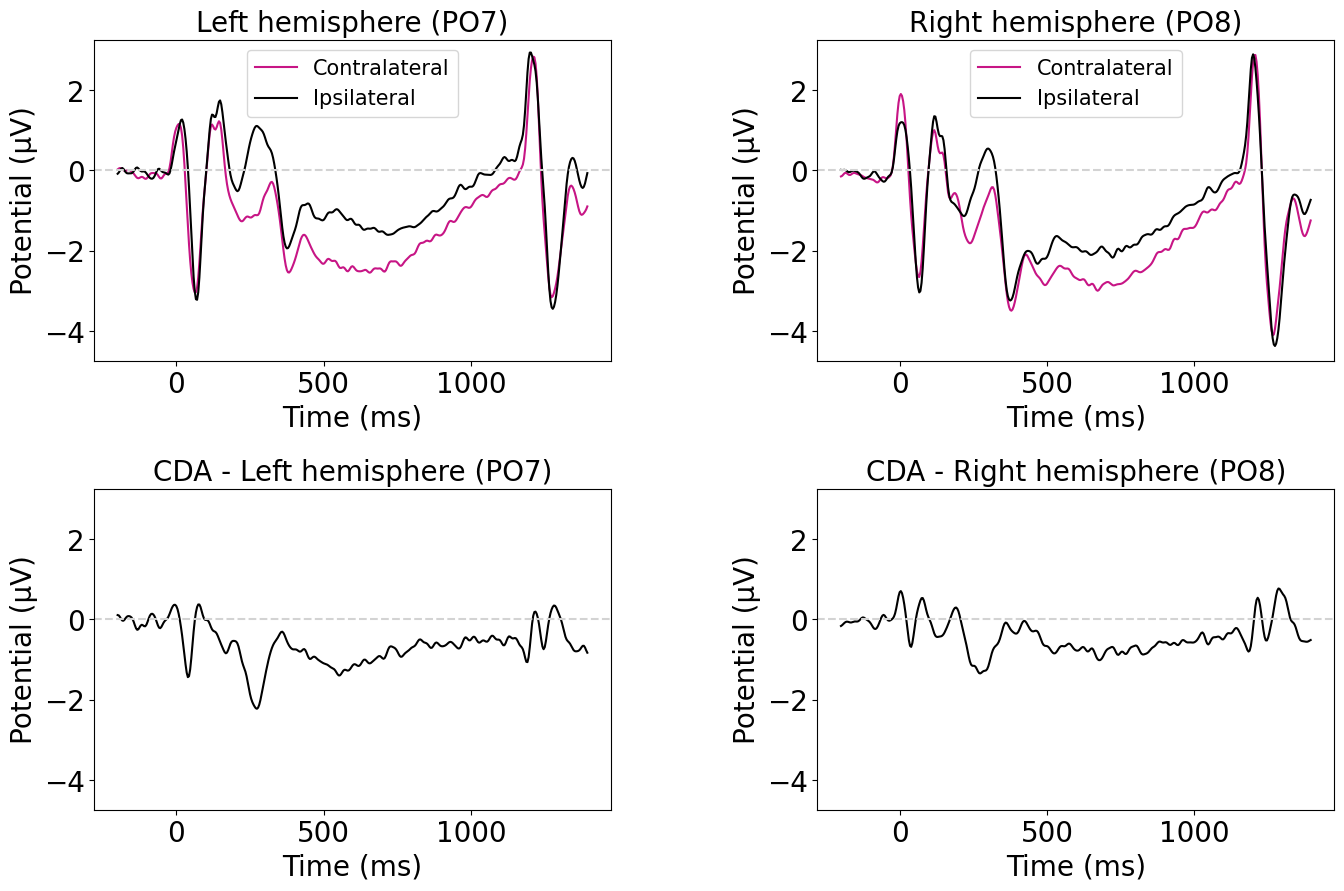

In [10]:
plot_CDA_hemispheres(waves_for_plotting, 'CDA_hemispheres.png')

## **Average CDA Amplitude**

#### Visual Inspection to Select a Time Window for Calculating the Average CDA

In [11]:
def plot_CDA_averaged(waves_for_plotting, start_time_window = None, end_time_window = None, save_path = None):
    """
    The function plots ipsi- and contra-lateral waves alongside the CDA wave, all averaged across hemispheres.

    This function is designed to aid in selecting an appropriate time window for calculating the average CDA amplitude. 

    When specified, it adds a shaded area to the plots, marking a selected time window.

    - excel_file: A dictionary containing pre-calculated ipsilateral, contralateral, and CDA waves DataFrames for each hemisphere.
    - start_time_window, end_time_window (optional): Start and end times (in milliseconds) of the time window to be highlighted.
    - save_path (optional): path to the output png file
    
    """
    fig, axs = plt.subplots(2, figsize = (8, 7))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

    label_font_size = 16 
    title_font_size = 18 
    tick_font_size = 14 
    legend_font_size = 15

    # Ipsi- and contra-lateral waves
    axs[0].plot(waves_for_plotting['avg_PO8_PO7']['time'], waves_for_plotting['avg_PO8_PO7']['avg_contra_combined'], color = 'mediumvioletred', label = 'Contralateral')
    axs[0].plot(waves_for_plotting['avg_PO8_PO7']['time'], waves_for_plotting['avg_PO8_PO7']['avg_ipsi_combined'], color = 'black', label = 'Ipsilateral')
    axs[0].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[0].set_title('', fontsize = title_font_size)
    axs[0].set_xlabel('Time (ms)', fontsize = label_font_size)
    axs[0].set_ylabel('Potential (uV)', fontsize = label_font_size)
    axs[0].legend(fontsize = legend_font_size)
    axs[0].tick_params(labelsize = tick_font_size)

    # CDA for averaged hemispheres
    axs[1].plot(waves_for_plotting['avg_PO8_PO7']['time'], waves_for_plotting['avg_PO8_PO7']['avg_cda_combined'], color = 'black')
    axs[1].axhline(0, color = 'lightgrey', linestyle = '--')
    axs[1].set_title('CDA', fontsize = title_font_size)
    axs[1].set_xlabel('Time (ms)', fontsize = label_font_size)
    axs[1].set_ylabel('Potential (uV)', fontsize = label_font_size)
    axs[1].tick_params(labelsize = tick_font_size)

    # Set the same y-axis limits for all subplots
    all_axes = [axs[0], axs[1]]
    ymin, ymax = min(ax.get_ylim()[0] for ax in all_axes), max(ax.get_ylim()[1] for ax in all_axes)
    for ax in all_axes:
        ax.set_ylim([ymin, ymax])

    # Add ticks at every 200 ms for x-axis
    for ax in all_axes:
        ax.set_xticks(np.arange(0, waves_for_plotting['avg_PO8_PO7']['time'].max(), 200))

    # If specified, highlight the specific time window
    if start_time_window is not None and end_time_window is not None:
        for ax in all_axes:
            rect = Rectangle((start_time_window, ymin), end_time_window - start_time_window, ymax - ymin, color = 'grey', alpha = 0.3, zorder = 1)
            ax.add_patch(rect)
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi = 300)  
       
    plt.show()

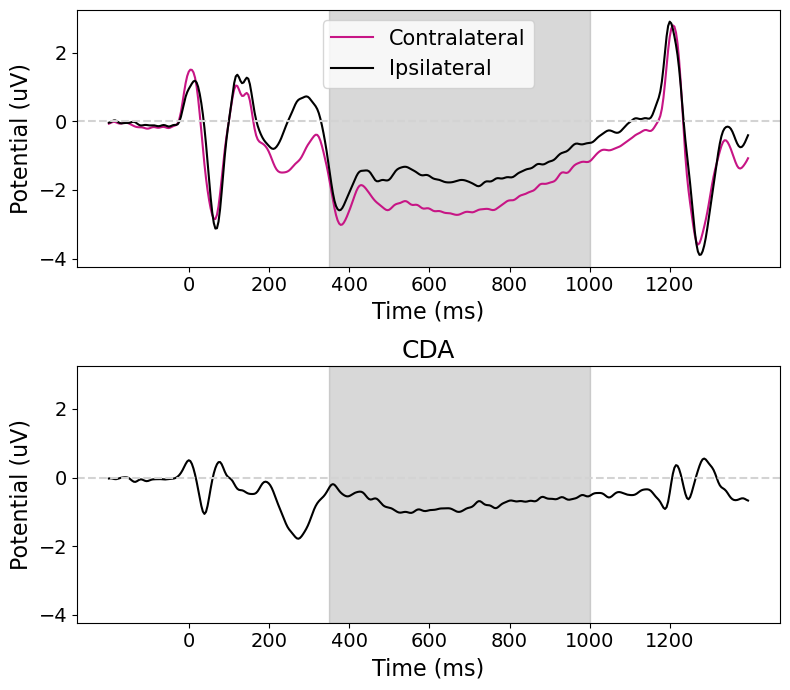

In [12]:
plot_CDA_averaged(waves_for_plotting, start_time_window = 350, end_time_window = 1000, save_path = "CDA_time_window.png" )

**The time window from 350 ms to 1000 ms was selected to calculate average CDA amplitude**

## **Calculate Average CDA Amplitude**

In this analysis, the mean CDA is determined by averaging the CDA values from both hemispheres within the specified time window, without separating the hemispheres. 

In [13]:
PO7_contra_ipsi_CDA_removed_subjects.keys()

dict_keys(['ipsi', 'contra', 'CDA', 'CDA_3', 'CDA_4', '3R', '3L', '4R', '4L'])

In [14]:
def calculate_avg_cda_amplitudes(po7_data, po8_data, start_time_window, end_time_window, output_file_path=None):
    """
    Extracts average CDA amplitude within a specified time window for each participant. 
    For this analysis, CDA averaged across both hemispheres is used. 

    Additionally (as a supplementary analysis), averaged amplitudes from the left (PO7) and right (PO8) hemispheres are calculated and stored in a dedicated Excel sheet.

    - po7_data: Dictionary of DataFrames for the PO7 hemisphere data.
    - po8_data: Dictionary of DataFrames for the PO8 hemisphere data.
    - start_time_window, end_time_window: Start and end times (in milliseconds) of the time window to be highlighted.
    - output_file_path (optional): Path to save the extracted avg CDA amplitudes as an Excel file.
    """
    # CDA data
    po7_cda = po7_data['CDA']
    po8_cda = po8_data['CDA']
    
    # Filter CDA values for the specified time window
    po7_cda_filtered_window = po7_cda[(po7_cda['time'] >= start_time_window) & (po7_cda['time'] <= end_time_window)]
    po8_cda_filtered_window = po8_cda[(po8_cda['time'] >= start_time_window) & (po8_cda['time'] <= end_time_window)]
    
    # Calculate average CDA values over hemispheres for the given time window (excluding the time column)
    combined_cda_filtered_window = (po7_cda_filtered_window.iloc[:, 1:] + po8_cda_filtered_window.iloc[:, 1:]) / 2

    # Calculate the average CDA amplitude for each subject in PO7 and PO8
    avg_cda_po7 = po7_cda_filtered_window.iloc[:, 1:].mean(axis=0).reset_index()
    avg_cda_po7.columns = ['id', 'avg_cda_po7']
    avg_cda_po8 = po8_cda_filtered_window.iloc[:, 1:].mean(axis=0).reset_index()
    avg_cda_po8.columns = ['id', 'avg_cda_po8']

    # Merge PO7 and PO8 data
    avg_cda_po7_po8 = avg_cda_po7.merge(avg_cda_po8, on = 'id', how = 'outer')

    # Calculate the average CDA amplitude for the combined data
    avg_cda_combined = combined_cda_filtered_window.mean(axis = 0).reset_index()
    avg_cda_combined.columns = ['id', 'avg_cda_combined']


    # Write the data to Excel if an output path is provided
    if output_file_path:
        with pd.ExcelWriter(output_file_path, engine = 'openpyxl') as writer:
            avg_cda_combined.to_excel(writer, sheet_name = 'avg_cda_combined', index = False)
            avg_cda_po7_po8.to_excel(writer, sheet_name = 'avg_cda_po7_po8', index = False)

    return avg_cda_combined, avg_cda_po7_po8

In [15]:
avg_cda_combined, avg_cda_po7_po8 = calculate_avg_cda_amplitudes(PO7_contra_ipsi_CDA_removed_subjects, PO8_contra_ipsi_CDA_removed_subjects, 350, 1000, 'avg_cda_amplitudes.xlsx')

### Extracting average CDA at different stimuli number conditions (3 or 4 stimuli)

In [16]:
def calculate_avg_cda_amplitudes_3_4_stimuli(po7_data, po8_data, start_time_window, end_time_window, output_file_path=None):
    """
    Extracts average CDA amplitude within a specified time window for each participant. 
    Extacts CDA amplitudes for different stimuli number conditions (3 and 4 stimuli)
    
    - po7_data: Dictionary of DataFrames for the PO7 hemisphere data.
    - po8_data: Dictionary of DataFrames for the PO8 hemisphere data.
    - start_time_window, end_time_window: Start and end times (in milliseconds) of the time window to be highlighted.
    - output_file_path (optional): Path to save the extracted avg CDA amplitudes as an Excel file.
    """
    # CDA data
    
    po7_cda_3 = po7_data['CDA_3']
    po8_cda_3 = po8_data['CDA_3']
    
    po7_cda_4 = po7_data['CDA_4']
    po8_cda_4 = po8_data['CDA_4']
    
    # Filter CDA values for the specified time window

    po7_cda_3_filtered_window = po7_cda_3[(po7_cda_3['time'] >= start_time_window) & (po7_cda_3['time'] <= end_time_window)]
    po8_cda_3_filtered_window = po8_cda_3[(po8_cda_3['time'] >= start_time_window) & (po8_cda_3['time'] <= end_time_window)]

    po7_cda_4_filtered_window = po7_cda_4[(po7_cda_4['time'] >= start_time_window) & (po7_cda_4['time'] <= end_time_window)]
    po8_cda_4_filtered_window = po8_cda_4[(po8_cda_4['time'] >= start_time_window) & (po8_cda_4['time'] <= end_time_window)]
    
    # Calculate average CDA values over hemispheres for the given time window
    combined_cda_3_filtered_window = (po7_cda_3_filtered_window.iloc[:, 1:] + po8_cda_3_filtered_window.iloc[:, 1:]) / 2

    combined_cda_4_filtered_window = (po7_cda_4_filtered_window.iloc[:, 1:] + po8_cda_4_filtered_window.iloc[:, 1:]) / 2

    # Calculate the average CDA amplitude for each subject in PO7 and PO8
    
    avg_cda_3_po7 = po7_cda_3_filtered_window.iloc[:, 1:].mean(axis = 0).reset_index()
    avg_cda_3_po7.columns = ['id', 'avg_cda_po7_3_stim']
    avg_cda_3_po8 = po8_cda_3_filtered_window.iloc[:, 1:].mean(axis = 0).reset_index()
    avg_cda_3_po8.columns = ['id', 'avg_cda_po8_3_stim']

    avg_cda_4_po7 = po7_cda_4_filtered_window.iloc[:, 1:].mean(axis = 0).reset_index()
    avg_cda_4_po7.columns = ['id', 'avg_cda_po7_4_stim']
    avg_cda_4_po8 = po8_cda_4_filtered_window.iloc[:, 1:].mean(axis = 0).reset_index()
    avg_cda_4_po8.columns = ['id', 'avg_cda_po8_4_stim']


    # Merge the data
    avg_cda_po7_po8_3_4_stim = avg_cda_3_po7.merge(avg_cda_3_po8, on = 'id', how = 'outer')
    avg_cda_po7_po8_3_4_stim = avg_cda_po7_po8_3_4_stim.merge(avg_cda_4_po7, on = 'id', how = 'outer')
    avg_cda_po7_po8_3_4_stim = avg_cda_po7_po8_3_4_stim.merge(avg_cda_4_po8, on = 'id', how = 'outer')


    # Calculate the average CDA amplitude for the combined data
    avg_cda_combined_3 = combined_cda_3_filtered_window.mean(axis = 0).reset_index()
    avg_cda_combined_3.columns = ['id', 'avg_cda_combined_3_stim']

    avg_cda_combined_4 = combined_cda_4_filtered_window.mean(axis = 0).reset_index()
    avg_cda_combined_4.columns = ['id', 'avg_cda_combined_4_stim']

    # Merge the data
    avg_cda_combined_3_4_stim = avg_cda_combined_3.merge(avg_cda_combined_4, on = 'id', how = 'outer')

    # Write the data to Excel if an output path is provided
    if output_file_path:
        with pd.ExcelWriter(output_file_path, engine = 'openpyxl') as writer:
            avg_cda_combined_3_4_stim.to_excel(writer, sheet_name = 'avg_cda_combined_3_4_stimuli', index = False)
            avg_cda_po7_po8_3_4_stim.to_excel(writer, sheet_name = 'avg_cda_po7_po8_3_4_stimuli', index = False)

    return avg_cda_combined_3_4_stim, avg_cda_po7_po8_3_4_stim

In [17]:
avg_cda_combined_3_4_stim, avg_cda_po7_po8_3_4_stim = calculate_avg_cda_amplitudes_3_4_stimuli(PO7_contra_ipsi_CDA_removed_subjects, PO8_contra_ipsi_CDA_removed_subjects, 350, 1000, 'avg_cda_amplitudes_3_4_stimuli.xlsx')

# Prepare the Data for Stats

In [18]:
avg_cda_po7_po8_3_4_stim = pd.read_excel('avg_cda_amplitudes_3_4_stimuli.xlsx', sheet_name = 'avg_cda_po7_po8_3_4_stimuli')

## Reshape the Data

In [19]:
avg_cda_po7_po8_3_4_stim

,id,avg_cda_po7_3_stim,avg_cda_po8_3_stim,avg_cda_po7_4_stim,avg_cda_po8_4_stim
0,101,-2.699969,-1.090596,-2.695858,0.342763
1,103,-0.284679,-0.952377,1.393481,-2.172913
2,104,-1.676450,-0.585386,-1.708052,0.102612
3,105,-0.072374,-1.117466,-2.045397,0.906246
4,106,-0.945670,-0.268077,-1.144438,-1.164237
...,...,...,...,...,...
160,638,1.023344,-1.356028,1.344751,-0.847430
161,639,-1.177687,-1.600528,-2.505539,1.458960
162,7,-0.921415,-0.784740,-1.664198,-1.174652
163,8,-4.236724,-1.027401,1.571955,-3.991063


In [20]:
avg_cda_po7_po8_3_4_stim.columns

Index(['id', 'avg_cda_po7_3_stim', 'avg_cda_po8_3_stim', 'avg_cda_po7_4_stim',
       'avg_cda_po8_4_stim'],
      dtype='object')

In [21]:
# Reshaping the data to a long format
avg_cda_condition = avg_cda_po7_po8_3_4_stim.melt(id_vars = ["id"], 
                  value_vars = ["avg_cda_po7_3_stim", "avg_cda_po8_3_stim", 
                              "avg_cda_po7_4_stim", "avg_cda_po8_4_stim"],
                  var_name = "condition", 
                  value_name = "mean_cda")

In [22]:
avg_cda_condition

,id,condition,mean_cda
0,101,avg_cda_po7_3_stim,-2.699969
1,103,avg_cda_po7_3_stim,-0.284679
2,104,avg_cda_po7_3_stim,-1.676450
3,105,avg_cda_po7_3_stim,-0.072374
4,106,avg_cda_po7_3_stim,-0.945670
...,...,...,...
655,638,avg_cda_po8_4_stim,-0.847430
656,639,avg_cda_po8_4_stim,1.458960
657,7,avg_cda_po8_4_stim,-1.174652
658,8,avg_cda_po8_4_stim,-3.991063


In [23]:
# Mapping conditions
conditions = {
    "avg_cda_po7_3_stim": ("3_stim", "left"),
    "avg_cda_po8_3_stim": ("3_stim", "right"),
    "avg_cda_po7_4_stim": ("4_stim", "left"),
    "avg_cda_po8_4_stim": ("4_stim", "right")
}

In [24]:
# Apply mapping
# To split condition into stimuli count and hemisphere columns
avg_cda_condition['stimuli_count'] = avg_cda_condition['condition'].map(lambda x: conditions[x][0])
avg_cda_condition['hemisphere'] = avg_cda_condition['condition'].map(lambda x: conditions[x][1])

In [25]:
avg_cda_condition.head()

,id,condition,mean_cda,stimuli_count,hemisphere
0,101,avg_cda_po7_3_stim,-2.699969,3_stim,left
1,103,avg_cda_po7_3_stim,-0.284679,3_stim,left
2,104,avg_cda_po7_3_stim,-1.676450,3_stim,left
3,105,avg_cda_po7_3_stim,-0.072374,3_stim,left
4,106,avg_cda_po7_3_stim,-0.945670,3_stim,left


In [26]:
# Remove condition column
avg_cda_condition.drop("condition", axis=1, inplace=True)

In [27]:
avg_cda_condition.head()

,id,mean_cda,stimuli_count,hemisphere
0,101,-2.699969,3_stim,left
1,103,-0.284679,3_stim,left
2,104,-1.676450,3_stim,left
3,105,-0.072374,3_stim,left
4,106,-0.945670,3_stim,left


## Add Group Column

In [28]:
def assign_group_label(df):
    """
    Based on the participant ID, adds a group label to the participant, as a value in new "group" column.
    
    """
    def determine_group(id_value):
        if id_value < 100:
            return 'OC'
        elif id_value < 200:
            return 'IUD'
        elif id_value < 300:
            return 'NCF'
        elif id_value < 400:
            return 'NCL'
        elif id_value > 400:
            return 'M'
        else:
            return 'Unknown'
    df = df.copy()  
    df['group'] = df['id'].apply(determine_group)
    
    return df

In [29]:
avg_cda_condition = assign_group_label(avg_cda_condition)

In [30]:
avg_cda_condition

,id,mean_cda,stimuli_count,hemisphere,group
0,101,-2.699969,3_stim,left,IUD
1,103,-0.284679,3_stim,left,IUD
2,104,-1.676450,3_stim,left,IUD
3,105,-0.072374,3_stim,left,IUD
4,106,-0.945670,3_stim,left,IUD
...,...,...,...,...,...
655,638,-0.847430,4_stim,right,M
656,639,1.458960,4_stim,right,M
657,7,-1.174652,4_stim,right,OC
658,8,-3.991063,4_stim,right,OC


In [31]:
avg_cda_condition.to_excel("avg_cda_condition.xlsx", index = False)